In [ ]:
!pip install pytorch-gan-metrics
!pip install pytorch-pretrained-biggan

In [3]:
# # note pytorch_gan_metrics is renamed to pytorch_image_generation_metrics
# import pytorch_image_generation_metrics

In [5]:
"""
Invert some images into another GAN and analyze their IS and FID
"""
import sys
import torch
import numpy as np
from pytorch_image_generation_metrics.utils import ImageDataset
from pytorch_image_generation_metrics.core  import torch_cov, get_inception_feature, calculate_inception_score, calculate_frechet_distance # type: ignore
# from pytorch_image_generation_metrics import get_inception_score, get_fid, get_inception_score_and_fid
from pytorch_pretrained_biggan import BigGAN
sys.path.append("/n/home12/binxuwang/Github/Neuro-ActMax-GAN-comparison")
from core.utils.GAN_utils import upconvGAN, BigGAN_wrapper, loadBigGAN
from core.utils import saveallforms, showimg, show_imgrid, save_imgrid
from core.utils.GAN_invert_utils import GAN_invert, GAN_invert_with_scheduler
from torchvision.transforms import Compose, Resize, ToTensor, CenterCrop, Normalize, Lambda

In [7]:
import os
from os.path import join
from typing import List, Union, Tuple, Optional
from glob import glob
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, GaussianBlur
from torchvision.transforms.functional import to_tensor
class ImageDataset_filter(Dataset):
    """An simple image dataset for calculating inception score and FID."""

    def __init__(self, root, glob_pattern="*", exts=['png', 'jpg', 'JPEG'], transform=None,
                 num_images=None):
        """Construct an image dataset.

        Args:
            root: Path to the image directory. This directory will be
                  recursively searched.
            exts: List of extensions to search for.
            transform: A torchvision transform to apply to the images. If
                       None, the images will be converted to tensors.
            num_images: The number of images to load. If None, all images
                        will be loaded.
        """
        self.paths = []
        self.transform = transform
        for ext in exts:
            self.paths.extend(
                list(glob(
                    os.path.join(root, glob_pattern+'.%s' % ext), recursive=True)))
        self.paths = self.paths[:num_images]

    def __len__(self):              # noqa
        return len(self.paths)

    def __getitem__(self, idx):     # noqa
        image = Image.open(self.paths[idx])
        image = image.convert('RGB')        # fix ImageNet grayscale images
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = to_tensor(image)
        return image


In [15]:
!echo $STORE_DIR/Datasets/GAN_sample_fid

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/GAN_sample_fid


### Calculate stats for some image sets

In [3]:
rootdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/GAN_sample_fid"
sumdir = join(rootdir, "summary")
os.makedirs(sumdir, exist_ok=True)

In [51]:
with np.load(join(sumdir, f"{'INet'}_inception_stats.npz")) as f:
    mu_INet = f["mu"]
    sigma_INet = f["sigma"]

FileNotFoundError: [Errno 2] No such file or directory: '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/GAN_sample_fid/summary/INet_inception_stats.npz'

In [ ]:
imageset_str = "BigGAN_1000cls_std07"
imgroot = join(rootdir, "BigGAN_1000cls_std07_invert")
FCimgdataset = ImageDataset_filter(imgroot, glob_pattern="FC_invert*", transform=None)
BGimgdataset = ImageDataset_filter(imgroot, glob_pattern="BG*", transform=None)
BGBlurimgdataset = ImageDataset_filter(imgroot, glob_pattern="BG*",
                           transform=Compose([ToTensor(), GaussianBlur([15, 15], sigma=9)]))
print(len(FCimgdataset), len(BGimgdataset))

imgloader = DataLoader(FCimgdataset, batch_size=100, shuffle=False, num_workers=4, pin_memory=True)
with torch.no_grad():
    acts, probs = get_inception_feature(imgloader, dims=[2048, 1008], use_torch=True, verbose=True)
mu = torch.mean(acts, dim=0).cpu().numpy()
sigma = torch_cov(acts, rowvar=False).cpu().numpy()
np.savez_compressed(join(sumdir, f"{imageset_str}_FC_invert_inception_stats.npz"), mu=mu, sigma=sigma)
inception_score, IS_std = calculate_inception_score(probs, 10, use_torch=True)
fid_w_INet = calculate_frechet_distance(mu, sigma, mu_INet, sigma_INet, eps=1e-6)
np.savez(join(sumdir, f"{imageset_str}_FC_invert_IS_stats.npz"), IS=inception_score, IS_std=IS_std, FID=fid_w_INet)
print(imageset_str, "FC Inverted")
print("FID", fid_w_INet)
print("Inception Score", inception_score, IS_std)
#%%


In [ ]:
imgloader = DataLoader(BGimgdataset, batch_size=100, shuffle=False, num_workers=4, pin_memory=True)
with torch.no_grad():
    acts, probs = get_inception_feature(imgloader, dims=[2048, 1008], use_torch=True, verbose=True)
mu = torch.mean(acts, dim=0).cpu().numpy()
sigma = torch_cov(acts, rowvar=False).cpu().numpy()
np.savez_compressed(join(sumdir, f"{imageset_str}_BG_inception_stats.npz"), mu=mu, sigma=sigma)
inception_score, IS_std = calculate_inception_score(probs, 10, use_torch=True)
fid_w_INet = calculate_frechet_distance(mu, sigma, mu_INet, sigma_INet, eps=1e-6)
np.savez(join(sumdir, f"{imageset_str}_BG_IS_stats.npz"), IS=inception_score, IS_std=IS_std, FID=fid_w_INet)
print(imageset_str, "Original")
print("FID", fid_w_INet)
print("Inception Score", inception_score, IS_std)
#%%


In [ ]:
imgloader = DataLoader(BGBlurimgdataset, batch_size=100, shuffle=False, num_workers=4, pin_memory=True)
with torch.no_grad():
    acts, probs = get_inception_feature(imgloader, dims=[2048, 1008], use_torch=True, verbose=True)
mu = torch.mean(acts, dim=0).cpu().numpy()
sigma = torch_cov(acts, rowvar=False).cpu().numpy()
np.savez_compressed(join(sumdir, f"{imageset_str}_BGBlur_inception_stats.npz"), mu=mu, sigma=sigma)
inception_score, IS_std = calculate_inception_score(probs, 10, use_torch=True)
fid_w_INet = calculate_frechet_distance(mu, sigma, mu_INet, sigma_INet, eps=1e-6)
np.savez(join(sumdir, f"{imageset_str}_BGBlur_IS_stats.npz"), IS=inception_score, IS_std=IS_std, FID=fid_w_INet)
print(imageset_str, "Blur")
print("FID", fid_w_INet)
print("Inception Score", inception_score, IS_std)
#%%


In [ ]:
imageset_str = "resnet50_linf8_gradevol"
imgroot = join(rootdir, "resnet50_linf8_gradevol")
gradevolimgdataset = ImageDataset_filter(imgroot, glob_pattern="class*", transform=None)
print(len(gradevolimgdataset), )
imgloader = DataLoader(gradevolimgdataset, batch_size=100, shuffle=False, num_workers=4, pin_memory=True)
with torch.no_grad():
    acts, probs = get_inception_feature(imgloader, dims=[2048, 1008], use_torch=True, verbose=True)
mu = torch.mean(acts, dim=0).cpu().numpy()
sigma = torch_cov(acts, rowvar=False).cpu().numpy()
np.savez_compressed(join(sumdir, f"{imageset_str}_FC_gradevol_inception_stats.npz"), mu=mu, sigma=sigma)
inception_score, IS_std = calculate_inception_score(probs, 10, use_torch=True)
fid_w_INet = calculate_frechet_distance(mu, sigma, mu_INet, sigma_INet, eps=1e-6)
np.savez(join(sumdir, f"{imageset_str}_FC_gradevol_IS_stats.npz"), IS=inception_score, IS_std=IS_std, FID=fid_w_INet)
print(imageset_str, "FC Evolved")
print("FID", fid_w_INet)
print("Inception Score", inception_score, IS_std)

In [ ]:
imageset_str = "resnet50_linf8_gradevol_avgpool"
imgroot = join(rootdir, "resnet50_linf8_gradevol_avgpool")
gradevolimgdataset = ImageDataset_filter(imgroot, glob_pattern="class*", transform=None)
print(len(gradevolimgdataset), )
imgloader = DataLoader(gradevolimgdataset, batch_size=100, shuffle=False, num_workers=4, pin_memory=True)
with torch.no_grad():
    acts, probs = get_inception_feature(imgloader, dims=[2048, 1008], use_torch=True, verbose=True)
mu = torch.mean(acts, dim=0).cpu().numpy()
sigma = torch_cov(acts, rowvar=False).cpu().numpy()
np.savez_compressed(join(sumdir, f"{imageset_str}_FC_gradevol_inception_stats.npz"), mu=mu, sigma=sigma)
inception_score, IS_std = calculate_inception_score(probs, 10, use_torch=True)
fid_w_INet = calculate_frechet_distance(mu, sigma, mu_INet, sigma_INet, eps=1e-6)
np.savez(join(sumdir, f"{imageset_str}_FC_gradevol_IS_stats.npz"), IS=inception_score, IS_std=IS_std, FID=fid_w_INet)
print(imageset_str, "FC Evolved")
print("FID", fid_w_INet)
print("Inception Score", inception_score, IS_std)


In [ ]:
imageset_str = "resnet50_linf8_gradevol_layer4"
imgroot = join(rootdir, "resnet50_linf8_gradevol_layer4")
gradevolimgdataset = ImageDataset_filter(imgroot, glob_pattern="class*", transform=None)
print(len(gradevolimgdataset), )
imgloader = DataLoader(gradevolimgdataset, batch_size=100, shuffle=False, num_workers=4, pin_memory=True)
with torch.no_grad():
    acts, probs = get_inception_feature(imgloader, dims=[2048, 1008], use_torch=True, verbose=True)
mu = torch.mean(acts, dim=0).cpu().numpy()
sigma = torch_cov(acts, rowvar=False).cpu().numpy()
np.savez_compressed(join(sumdir, f"{imageset_str}_FC_gradevol_inception_stats.npz"), mu=mu, sigma=sigma)
inception_score, IS_std = calculate_inception_score(probs, 10, use_torch=True)
fid_w_INet = calculate_frechet_distance(mu, sigma, mu_INet, sigma_INet, eps=1e-6)
np.savez(join(sumdir, f"{imageset_str}_FC_gradevol_IS_stats.npz"), IS=inception_score, IS_std=IS_std, FID=fid_w_INet)
print(imageset_str, "FC Evolved")
print("FID", fid_w_INet)
print("Inception Score", inception_score, IS_std)

In [ ]:
imageset_str = "resnet50_linf8_gradevol_layer3"
imgroot = join(rootdir, "resnet50_linf8_gradevol_layer3")
gradevolimgdataset = ImageDataset_filter(imgroot, glob_pattern="class*", transform=None)
print(len(gradevolimgdataset), )
imgloader = DataLoader(gradevolimgdataset, batch_size=100, shuffle=False, num_workers=4, pin_memory=True)
with torch.no_grad():
    acts, probs = get_inception_feature(imgloader, dims=[2048, 1008], use_torch=True, verbose=True)
mu = torch.mean(acts, dim=0).cpu().numpy()
sigma = torch_cov(acts, rowvar=False).cpu().numpy()
np.savez_compressed(join(sumdir, f"{imageset_str}_FC_gradevol_inception_stats.npz"), mu=mu, sigma=sigma)
inception_score, IS_std = calculate_inception_score(probs, 10, use_torch=True)
fid_w_INet = calculate_frechet_distance(mu, sigma, mu_INet, sigma_INet, eps=1e-6)
np.savez(join(sumdir, f"{imageset_str}_FC_gradevol_IS_stats.npz"), IS=inception_score, IS_std=IS_std, FID=fid_w_INet)
print(imageset_str, "FC Evolved")
print("FID", fid_w_INet)
print("Inception Score", inception_score, IS_std)

### Stats for other reference image sets

In [27]:
!ls $STORE_DIR/Datasets/

2020-BigGAN.zip
2021-EvolDecomp.zip
COCO_dataset
downloads
EDM_datasets
GAN_sample_fid
ILSVRC
ILSVRC_meta
_image_database_things.zip
imagenet-object-localization-challenge.zip
imagenet-valid
kietzmannlab___ecoset
_n_holylfs06_LABS_kempner_fellow_binxuwang_Users_binxuwang_Datasets_kietzmannlab___ecoset_Full_1.1.0_e3a31781b8f6e203301f121c75bab4afaf9d51f2d8dd40c3c8e5954ad6d02712.lock
object_images
RPM_dataset
single-neurons-as-deep-nets-nmda-test-data.zip
single-neurons-as-deep-nets-nmda-train-data.zip
single_neurons_DNN_train
Stimuli
THINGS_database


In [54]:
dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/"
ImageNet_root = join(dataset_root, "imagenet-valid")
COCO_root = join(dataset_root, "COCO_dataset")
THINGS_root = join(dataset_root, "THINGS_database")
ECOSET_root = join(dataset_root, "kietzmannlab___ecoset")

In [57]:
dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/"
COCO_root = join(dataset_root, "COCO_dataset")
THINGS_root = join(dataset_root, "THINGS_database") 
ECOSET_root = join(dataset_root, "kietzmannlab___ecoset")
ImageNet_root = join(dataset_root, "imagenet-valid")

ImageNet_dataset = ImageDataset(ImageNet_root, transform=None) # glob_pattern="*.png",
THINGS_dataset = ImageDataset(THINGS_root, transform=None) # glob_pattern="*.png",
COCO_dataset = ImageDataset(COCO_root, transform=None) # glob_pattern="*.jpg",
# ECOSET_dataset = ImageDataset(ECOSET_root, transform=None) # glob_pattern="*.jpg",

print(f"THINGS dataset size: {len(THINGS_dataset)}")
print(f"COCO dataset size: {len(COCO_dataset)}")
print(f"ImageNet dataset size: {len(ImageNet_dataset)}")
# print(f"ECOSET dataset size: {len(ECOSET_dataset)}")

THINGS dataset size: 26107
COCO dataset size: 123287
ImageNet dataset size: 50000


#### THINGS vision 

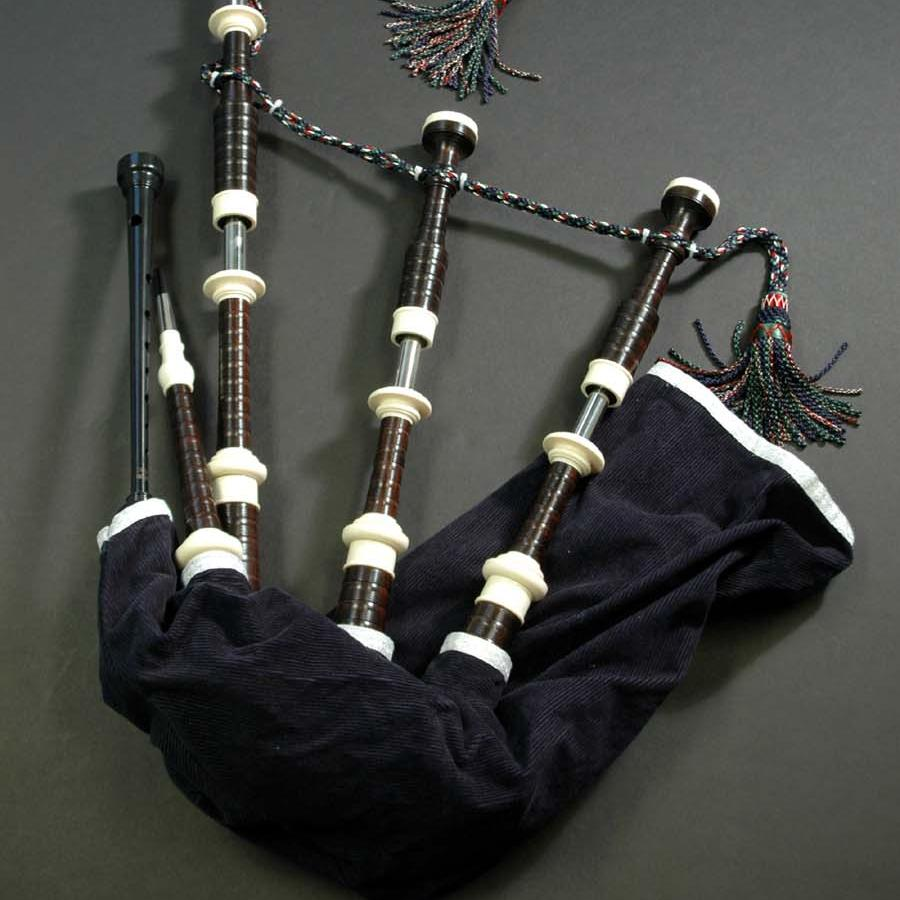

In [47]:
THINGS_dataset = ImageDataset(THINGS_root, transform=lambda x: x)
THINGS_dataset[0]

InceptionV3 will use `normalize_input` and `resize_input` by default. 
```
def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False,
                 use_fid_inception=True):
```

In [4]:
from torchvision.transforms import Compose, Resize, ToTensor, CenterCrop, Normalize, Lambda

In [66]:
imageset_str = "ImageNet_valid"
INet_dataset = ImageDataset(ImageNet_root, transform=Compose([Resize(299), 
                                                              ToTensor(), 
                                                              CenterCrop(299), ]))
loader = DataLoader(INet_dataset, batch_size=80, num_workers=os.cpu_count())
acts, probs = get_inception_feature(
    loader, dims=[2048, 1008], use_torch=True, verbose=True)

mu = torch.mean(acts, dim=0).cpu().numpy()
sigma = torch_cov(acts, rowvar=False).cpu().numpy()
np.savez_compressed(join(sumdir, f"{imageset_str}_inception_stats.npz"), mu=mu, sigma=sigma)
inception_score, IS_std = calculate_inception_score(probs, 10, use_torch=True)
print(imageset_str, "Inception Score", inception_score, IS_std)
# fid_w_INet = calculate_frechet_distance(mu, sigma, mu_INet, sigma_INet, eps=1e-6)
np.savez(join(sumdir, f"{imageset_str}_IS_stats.npz"), IS=inception_score, IS_std=IS_std, FID=None)

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

ImageNet_valid Inception Score 240.3596649169922 3.5258731842041016


In [67]:
with np.load(join(sumdir, f"{'ImageNet_valid'}_inception_stats.npz")) as f:
    mu_INet = f["mu"]
    sigma_INet = f["sigma"]


#### THINGS vision

In [68]:
imageset_str = "THINGS_vision"
THINGS_dataset = ImageDataset(THINGS_root, transform=Compose([Resize(299), 
                                                              ToTensor(), 
                                                              CenterCrop(299), ]))
loader = DataLoader(THINGS_dataset, batch_size=80, num_workers=os.cpu_count())
acts, probs = get_inception_feature(
    loader, dims=[2048, 1008], use_torch=True, verbose=True)

mu = torch.mean(acts, dim=0).cpu().numpy()
sigma = torch_cov(acts, rowvar=False).cpu().numpy()
np.savez_compressed(join(sumdir, f"{imageset_str}_inception_stats.npz"), mu=mu, sigma=sigma)
inception_score, IS_std = calculate_inception_score(probs, 10, use_torch=True)
fid_w_INet = calculate_frechet_distance(mu, sigma, mu_INet, sigma_INet, eps=1e-6)
print(imageset_str, "num_images", len(THINGS_dataset))
print(imageset_str, "Inception Score", inception_score, IS_std)
print("FID", fid_w_INet)
np.savez(join(sumdir, f"{imageset_str}_IS_stats.npz"), IS=inception_score, IS_std=IS_std, FID=fid_w_INet)

get_inception_feature:   0%|          | 0/26107 [00:00<?, ?it/s]

THINGS_vision num_images 26107
THINGS_vision Inception Score 41.5648078918457 2.6174604892730713
FID 21.803375244140625


In [65]:
print(imageset_str, "num_images", len(THINGS_dataset))
print("Inception Score", inception_score, IS_std)
print("FID", fid_w_INet)

THINGS_vision num_images 26107
Inception Score 40.26454544067383 2.5987277030944824
FID 21.7042236328125


#### COCO 

In [69]:
imageset_str = "COCO"
COCO_dataset = ImageDataset(COCO_root, transform=Compose([Resize(299), 
                                                            ToTensor(), 
                                                            CenterCrop(299), ]))
loader = DataLoader(COCO_dataset, batch_size=80, num_workers=os.cpu_count())
acts, probs = get_inception_feature(
    loader, dims=[2048, 1008], use_torch=True, verbose=True)

mu = torch.mean(acts, dim=0).cpu().numpy()
sigma = torch_cov(acts, rowvar=False).cpu().numpy()
np.savez_compressed(join(sumdir, f"{imageset_str}_inception_stats.npz"), mu=mu, sigma=sigma)
inception_score, IS_std = calculate_inception_score(probs, 10, use_torch=True)
fid_w_INet = calculate_frechet_distance(mu, sigma, mu_INet, sigma_INet, eps=1e-6)
print(imageset_str, "num_images", len(COCO_dataset))
print("Inception Score", inception_score, IS_std)
print("FID", fid_w_INet)
np.savez(join(sumdir, f"{imageset_str}_IS_stats.npz"), IS=inception_score, IS_std=IS_std, FID=fid_w_INet)

get_inception_feature:   0%|          | 0/123287 [00:00<?, ?it/s]

COCO num_images 123287
Inception Score 39.16073989868164 0.32236576080322266
FID 43.620330810546875


#### ECOSET

In [ ]:
from torchvision.transforms import Lambda
from datasets import load_dataset, concatenate_datasets
dataset = load_dataset("kietzmannlab/ecoset", verification_mode="no_checks", 
                       cache_dir='/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets')

Using the latest cached version of the module from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/hf/misc/modules/datasets_modules/datasets/kietzmannlab--ecoset/e3a31781b8f6e203301f121c75bab4afaf9d51f2d8dd40c3c8e5954ad6d02712 (last modified on Sun Nov 17 17:48:05 2024) since it couldn't be found locally at kietzmannlab/ecoset, or remotely on the Hugging Face Hub.


In [88]:
print(dataset["train"])
print(dataset["validation"])
print(dataset["test"])

Dataset({
    features: ['image', 'label'],
    num_rows: 1444911
})
Dataset({
    features: ['image', 'label'],
    num_rows: 28250
})
Dataset({
    features: ['image', 'label'],
    num_rows: 28250
})


In [91]:
imageset_str = "Ecoset"
dataset = load_dataset("kietzmannlab/ecoset", verification_mode="no_checks", 
                       cache_dir='/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets')
img_transform = Compose([Resize(299),
                         Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # Ensure RGB
                         ToTensor(),
                         CenterCrop(299),
                        ])
# Preprocessing function
def preprocess(batch):
    # Convert images to PyTorch tensors
    batch["image"] = [img_transform(img) for img in batch["image"]]
    return  batch 
Ecoset_dataset = concatenate_datasets([dataset["validation"], dataset["test"]])
Ecoset_dataset.set_transform(preprocess)
loader = DataLoader(Ecoset_dataset, 
                    batch_size=80, 
                    shuffle=False,
                    num_workers=os.cpu_count(),
                    collate_fn=lambda x: torch.stack([item["image"] for item in x], dim=0))
acts, probs = get_inception_feature(
    loader, dims=[2048, 1008], use_torch=True, verbose=True)

mu = torch.mean(acts, dim=0).cpu().numpy()
sigma = torch_cov(acts, rowvar=False).cpu().numpy()
np.savez_compressed(join(sumdir, f"{imageset_str}_inception_stats.npz"), mu=mu, sigma=sigma)
inception_score, IS_std = calculate_inception_score(probs, 10, use_torch=True)
fid_w_INet = calculate_frechet_distance(mu, sigma, mu_INet, sigma_INet, eps=1e-6)
print(imageset_str, "num_images", len(Ecoset_dataset))
print("Inception Score", inception_score, IS_std)
print("FID", fid_w_INet)
np.savez(join(sumdir, f"{imageset_str}_IS_stats.npz"), IS=inception_score, IS_std=IS_std, FID=fid_w_INet)

Using the latest cached version of the module from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/hf/misc/modules/datasets_modules/datasets/kietzmannlab--ecoset/e3a31781b8f6e203301f121c75bab4afaf9d51f2d8dd40c3c8e5954ad6d02712 (last modified on Sun Nov 17 17:48:05 2024) since it couldn't be found locally at kietzmannlab/ecoset, or remotely on the Hugging Face Hub.


get_inception_feature:   0%|          | 0/56500 [00:00<?, ?it/s]

Ecoset num_images 56500
Inception Score 46.68861770629883 3.9744937419891357
FID 21.14141845703125


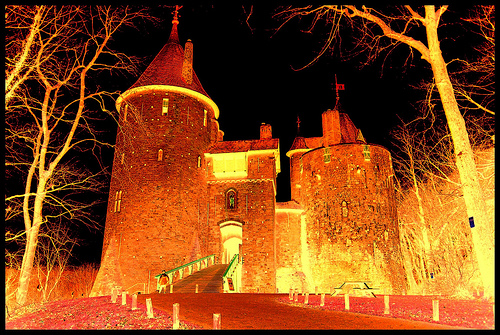

In [87]:
dataset["validation"][201]["image"]

### Synopsis

In [8]:
sumdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/GAN_sample_fid/summary"

In [9]:
imageset_list = ["ImageNet_valid", "THINGS_vision", "COCO", "Ecoset"] 
for imageset_str in imageset_list:
    with np.load(join(sumdir, f"{imageset_str}_IS_stats.npz"), allow_pickle=True) as f:
        IS = f["IS"]
        IS_std = f["IS_std"]
        FID = f["FID"]
    print(imageset_str, f"Inception Score {IS:.3f} ± {IS_std:.3f} ")
    if not np.issubdtype(FID.dtype, np.number):
        print(imageset_str, f"FID {FID}")
    else:
        print(imageset_str, f"FID {FID:.3f}")


ImageNet_valid Inception Score 240.360 ± 3.526 
ImageNet_valid FID None
THINGS_vision Inception Score 41.565 ± 2.617 
THINGS_vision FID 21.803
COCO Inception Score 39.161 ± 0.322 
COCO FID 43.620
Ecoset Inception Score 46.689 ± 3.974 
Ecoset FID 21.141


#### Measure distance to all the references

In [10]:
GANimgroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/GAN_sample_fid"
default_tfm = Compose([
    ToTensor(),
    CenterCrop(256),
])
imgroot = join(GANimgroot, "BigGAN_1000cls_std07_invert")
FCinvertdataset = ImageDataset_filter(imgroot, glob_pattern="FC_invert*", 
                            transform=default_tfm)
BGorigdataset = ImageDataset_filter(imgroot, glob_pattern="BG*", 
                            transform=default_tfm)
BGBlurdataset = ImageDataset_filter(imgroot, glob_pattern="BG*",
                            transform= Compose([
                               ToTensor(), 
                               GaussianBlur([15, 15], sigma=9),
                               Resize((256, 256)),
                               ]))
print(len(FCinvertdataset), len(BGorigdataset), len(BGBlurdataset))

imageset_str = "DeePSim_4std"
FCdataset = ImageDataset_filter(join(GANimgroot, "DeePSim_4std"), 
                    glob_pattern="sample*", transform=default_tfm)
print(imageset_str, len(FCdataset))
imageset_str = "BigGAN_trunc07"
BGdataset = ImageDataset_filter(join(GANimgroot, "BigGAN_trunc07"), 
                    glob_pattern="sample*", transform=default_tfm)
print(imageset_str, len(BGdataset))
imageset_str = "BigGAN_std_008"
BGRNDdataset = ImageDataset_filter(join(GANimgroot, "BigGAN_std_008"), 
                    glob_pattern="sample*", transform=default_tfm)
print(imageset_str, len(BGRNDdataset))

imageset_str = "resnet50_linf8_gradevol"
gradevoldataset_fc = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol"), 
                    glob_pattern="class*", transform=default_tfm)
print(imageset_str, len(gradevoldataset_fc))
imageset_str = "resnet50_linf8_gradevol_avgpool"
gradevoldataset_avgpool = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol_avgpool"), 
                    glob_pattern="class*", transform=default_tfm)
print(imageset_str, len(gradevoldataset_avgpool))
imageset_str = "resnet50_linf8_gradevol_layer4"
gradevoldataset_layer4 = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol_layer4"), 
                    glob_pattern="class*", transform=default_tfm)
print(imageset_str, len(gradevoldataset_layer4))
imageset_str = "resnet50_linf8_gradevol_layer3"
gradevoldataset_layer3 = ImageDataset_filter(join(GANimgroot, "resnet50_linf8_gradevol_layer3"), 
                    glob_pattern="class*", transform=default_tfm)
print(imageset_str, len(gradevoldataset_layer3))


21000 21000 21000
DeePSim_4std 50000
BigGAN_trunc07 50000
BigGAN_std_008 50000
resnet50_linf8_gradevol 50000
resnet50_linf8_gradevol_avgpool 51200
resnet50_linf8_gradevol_layer4 2332
resnet50_linf8_gradevol_layer3 51200


In [21]:
pinknoise_dataset = ImageDataset_filter(join(GANimgroot, "pink_noise"), 
                    glob_pattern="sample*", transform=default_tfm)
print(imageset_str, len(pinknoise_dataset))

BigGAN_Blur 50000


In [16]:
import pickle as pkl
refimageset_list = ["ImageNet_valid", "THINGS_vision", "COCO", "Ecoset"] 
generated_imageset_col = {"DeePSim_4std": FCdataset , 
                          "BigGAN_trunc07": BGdataset,
                          "BigGAN_std_008": BGRNDdataset,
                          "resnet50_linf8_gradevol": gradevoldataset_fc,
                          "resnet50_linf8_gradevol_avgpool": gradevoldataset_avgpool,
                          "resnet50_linf8_gradevol_layer3": gradevoldataset_layer3,
                          "FC_invert_BigGAN": FCinvertdataset,
                          "BigGAN_orig": BGorigdataset,
                          "BigGAN_Blur": BGBlurdataset,
                          "pink_noise": pinknoise_dataset,
                          }
fid_stats = []
IS_stats = []
for imageset_str, dataset in generated_imageset_col.items():
    print(imageset_str, "num_images", len(dataset))
    loader = DataLoader(dataset, batch_size=80, num_workers=os.cpu_count())
    acts, probs = get_inception_feature(
        loader, dims=[2048, 1008], use_torch=True, verbose=True)
    mu = torch.mean(acts, dim=0).cpu().numpy()
    sigma = torch_cov(acts, rowvar=False).cpu().numpy()
    np.savez_compressed(join(sumdir, f"{imageset_str}_inception_stats.npz"), mu=mu, sigma=sigma)
    inception_score, IS_std = calculate_inception_score(probs, 10, use_torch=True)
    print("Inception Score", inception_score, IS_std)
    np.savez(join(sumdir, f"{imageset_str}_IS_stats.npz"), IS=inception_score, IS_std=IS_std, )
    IS_stats.append({"dataset": imageset_str, "IS": inception_score, "IS_std": IS_std})
    for imageset_str_ref in refimageset_list:
        with np.load(join(sumdir, f"{imageset_str_ref}_inception_stats.npz"), allow_pickle=True) as f:
            mu_INet = f["mu"]
            sigma_INet = f["sigma"]
        # fid_w_INet = calculate_frechet_distance(mu, sigma, mu_INet, sigma_INet, eps=1e-6)
        fid_w_INet = calculate_frechet_distance(torch.tensor(mu).cuda(), torch.tensor(sigma).cuda(), 
                                            torch.tensor(mu_INet).cuda(), torch.tensor(sigma_INet).cuda(), 
                                            eps=1e-6, use_torch=True)
        print(f"{imageset_str} vs {imageset_str_ref}", "FID", fid_w_INet)
        fid_stats.append({"dataset1": imageset_str, "dataset2": imageset_str_ref, "FID": fid_w_INet})
    pkl.dump(fid_stats, open(join(sumdir, f"FID_stats_synopsis.pkl"), "wb"))
    pkl.dump(IS_stats, open(join(sumdir, f"IS_stats_synopsis.pkl"), "wb"))


DeePSim_4std num_images 50000


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

Inception Score 3.4009487628936768 0.04067743197083473
DeePSim_4std vs ImageNet_valid FID 242.09243774414062
DeePSim_4std vs THINGS_vision FID 247.41339111328125
DeePSim_4std vs COCO FID 223.54830932617188
DeePSim_4std vs Ecoset FID 236.02978515625
BigGAN_trunc07 num_images 50000


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

Inception Score 262.8195495605469 4.300715446472168
BigGAN_trunc07 vs ImageNet_valid FID 12.1512451171875
BigGAN_trunc07 vs THINGS_vision FID 37.14678955078125
BigGAN_trunc07 vs COCO FID 65.1688232421875
BigGAN_trunc07 vs Ecoset FID 37.308380126953125
BigGAN_std_008 num_images 50000


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

Inception Score 24.8640079498291 0.2810285985469818
BigGAN_std_008 vs ImageNet_valid FID 47.737030029296875
BigGAN_std_008 vs THINGS_vision FID 50.2945556640625
BigGAN_std_008 vs COCO FID 56.8687744140625
BigGAN_std_008 vs Ecoset FID 51.315460205078125
resnet50_linf8_gradevol num_images 50000


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

Inception Score 150.54295349121094 1.9983501434326172
resnet50_linf8_gradevol vs ImageNet_valid FID 42.790771484375
resnet50_linf8_gradevol vs THINGS_vision FID 60.123443603515625
resnet50_linf8_gradevol vs COCO FID 74.0130615234375
resnet50_linf8_gradevol vs Ecoset FID 55.233062744140625
resnet50_linf8_gradevol_avgpool num_images 51200


get_inception_feature:   0%|          | 0/51200 [00:00<?, ?it/s]

Inception Score 22.67959976196289 0.33756837248802185
resnet50_linf8_gradevol_avgpool vs ImageNet_valid FID 102.51168823242188
resnet50_linf8_gradevol_avgpool vs THINGS_vision FID 104.4674072265625
resnet50_linf8_gradevol_avgpool vs COCO FID 106.46221923828125
resnet50_linf8_gradevol_avgpool vs Ecoset FID 97.181884765625
resnet50_linf8_gradevol_layer3 num_images 51200


get_inception_feature:   0%|          | 0/51200 [00:00<?, ?it/s]

Inception Score 6.314107418060303 0.09913884103298187
resnet50_linf8_gradevol_layer3 vs ImageNet_valid FID 195.63711547851562
resnet50_linf8_gradevol_layer3 vs THINGS_vision FID 194.44235229492188
resnet50_linf8_gradevol_layer3 vs COCO FID 176.94717407226562
resnet50_linf8_gradevol_layer3 vs Ecoset FID 185.93887329101562
FC_invert_BigGAN num_images 21000


get_inception_feature:   0%|          | 0/21000 [00:00<?, ?it/s]

Inception Score 10.292155265808105 0.1570783108472824
FC_invert_BigGAN vs ImageNet_valid FID 154.06442260742188
FC_invert_BigGAN vs THINGS_vision FID 155.92572021484375
FC_invert_BigGAN vs COCO FID 148.94784545898438
FC_invert_BigGAN vs Ecoset FID 149.04571533203125
BigGAN_orig num_images 21000


get_inception_feature:   0%|          | 0/21000 [00:00<?, ?it/s]

Inception Score 204.07362365722656 4.713472366333008
BigGAN_orig vs ImageNet_valid FID 10.04547119140625
BigGAN_orig vs THINGS_vision FID 32.543731689453125
BigGAN_orig vs COCO FID 56.40380859375
BigGAN_orig vs Ecoset FID 32.11175537109375
BigGAN_Blur num_images 21000


get_inception_feature:   0%|          | 0/21000 [00:00<?, ?it/s]

Inception Score 47.82734298706055 1.2174676656723022
BigGAN_Blur vs ImageNet_valid FID 62.162078857421875
BigGAN_Blur vs THINGS_vision FID 74.74627685546875
BigGAN_Blur vs COCO FID 91.51034545898438
BigGAN_Blur vs Ecoset FID 64.08404541015625


In [22]:
for imageset_str, dataset in [("pink_noise", pinknoise_dataset)]:
    print(imageset_str, "num_images", len(dataset))
    loader = DataLoader(dataset, batch_size=80, num_workers=os.cpu_count())
    acts, probs = get_inception_feature(
        loader, dims=[2048, 1008], use_torch=True, verbose=True)
    mu = torch.mean(acts, dim=0).cpu().numpy()
    sigma = torch_cov(acts, rowvar=False).cpu().numpy()
    np.savez_compressed(join(sumdir, f"{imageset_str}_inception_stats.npz"), mu=mu, sigma=sigma)
    inception_score, IS_std = calculate_inception_score(probs, 10, use_torch=True)
    print("Inception Score", inception_score, IS_std)
    np.savez(join(sumdir, f"{imageset_str}_IS_stats.npz"), IS=inception_score, IS_std=IS_std, )
    IS_stats.append({"dataset": imageset_str, "IS": inception_score, "IS_std": IS_std})
    for imageset_str_ref in refimageset_list:
        with np.load(join(sumdir, f"{imageset_str_ref}_inception_stats.npz"), allow_pickle=True) as f:
            mu_INet = f["mu"]
            sigma_INet = f["sigma"]
        # fid_w_INet = calculate_frechet_distance(mu, sigma, mu_INet, sigma_INet, eps=1e-6)
        fid_w_INet = calculate_frechet_distance(torch.tensor(mu).cuda(), torch.tensor(sigma).cuda(), 
                                            torch.tensor(mu_INet).cuda(), torch.tensor(sigma_INet).cuda(), 
                                            eps=1e-6, use_torch=True)
        print(f"{imageset_str} vs {imageset_str_ref}", "FID", fid_w_INet)
        fid_stats.append({"dataset1": imageset_str, "dataset2": imageset_str_ref, "FID": fid_w_INet})
    pkl.dump(fid_stats, open(join(sumdir, f"FID_stats_synopsis.pkl"), "wb"))
    pkl.dump(IS_stats, open(join(sumdir, f"IS_stats_synopsis.pkl"), "wb"))

pink_noise num_images 50000


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

Inception Score 1.173435091972351 0.0037863869220018387
pink_noise vs ImageNet_valid FID 377.3529052734375
pink_noise vs THINGS_vision FID 394.88275146484375
pink_noise vs COCO FID 440.16339111328125
pink_noise vs Ecoset FID 401.6739501953125


In [24]:
fid_stats = pkl.load(open(join(sumdir, f"FID_stats_synopsis.pkl"), "rb"))
for imageset_str_ref1 in refimageset_list:
    with np.load(join(sumdir, f"{imageset_str_ref1}_inception_stats.npz"), allow_pickle=True) as f:
        mu_INet = f["mu"]
        sigma_INet = f["sigma"]
    for imageset_str_ref2 in refimageset_list:
        with np.load(join(sumdir, f"{imageset_str_ref2}_inception_stats.npz"), allow_pickle=True) as f:
            mu_INet2 = f["mu"]
            sigma_INet2 = f["sigma"]
        fid_1_w_2 = calculate_frechet_distance(torch.tensor(mu_INet).cuda(), torch.tensor(sigma_INet).cuda(), 
                                            torch.tensor(mu_INet2).cuda(), torch.tensor(sigma_INet2).cuda(), 
                                            eps=1e-6, use_torch=True)
        print(f"{imageset_str_ref1} vs {imageset_str_ref2}", "FID", fid_1_w_2)
        fid_stats.append({"dataset1": imageset_str_ref1, "dataset2": imageset_str_ref2, "FID": fid_1_w_2})
    pkl.dump(fid_stats, open(join(sumdir, f"FID_stats_synopsis.pkl"), "wb"))

ImageNet_valid vs ImageNet_valid FID -0.02325439453125
ImageNet_valid vs THINGS_vision FID 21.79754638671875
ImageNet_valid vs COCO FID 43.617889404296875
ImageNet_valid vs Ecoset FID 21.13189697265625
THINGS_vision vs ImageNet_valid FID 21.7926025390625
THINGS_vision vs THINGS_vision FID -0.018310546875
THINGS_vision vs COCO FID 45.89337158203125
THINGS_vision vs Ecoset FID 13.4554443359375
COCO vs ImageNet_valid FID 43.594268798828125
COCO vs THINGS_vision FID 45.89202880859375
COCO vs COCO FID -0.01763916015625
COCO vs Ecoset FID 43.304840087890625
Ecoset vs ImageNet_valid FID 21.13311767578125
Ecoset vs THINGS_vision FID 13.46240234375
Ecoset vs COCO FID 43.313079833984375
Ecoset vs Ecoset FID -0.023345947265625


In [27]:
IS_stats = pkl.load(open(join(sumdir, f"IS_stats_synopsis.pkl"), "rb"))
for imageset_str_ref in refimageset_list:
    with np.load(join(sumdir, f"{imageset_str_ref}_IS_stats.npz"), allow_pickle=True) as f:
        IS = f["IS"]
        IS_std = f["IS_std"]
    IS_stats.append({"dataset": imageset_str_ref, "IS": IS, "IS_std": IS_std})
pkl.dump(IS_stats, open(join(sumdir, f"IS_stats_synopsis.pkl"), "wb"))

In [28]:
import pandas as pd
fid_stats = pkl.load(open(join(sumdir, f"FID_stats_synopsis.pkl"), "rb"))
IS_stats = pkl.load(open(join(sumdir, f"IS_stats_synopsis.pkl"), "rb"))

fid_stats_df = pd.DataFrame(fid_stats)
IS_stats_df = pd.DataFrame(IS_stats)
fid_stats_df.to_csv(join(sumdir, f"FID_stats_synopsis.csv"), index=False)
IS_stats_df.to_csv(join(sumdir, f"IS_stats_synopsis.csv"), index=False)


In [29]:
IS_stats_df

,dataset,IS,IS_std
0,DeePSim_4std,3.400949,0.040677
1,BigGAN_trunc07,262.81955,4.300715
2,BigGAN_std_008,24.864008,0.281029
3,resnet50_linf8_gradevol,150.542953,1.99835
4,resnet50_linf8_gradevol_avgpool,22.6796,0.337568
5,resnet50_linf8_gradevol_layer3,6.314107,0.099139
6,FC_invert_BigGAN,10.292155,0.157078
7,BigGAN_orig,204.073624,4.713472
8,BigGAN_Blur,47.827343,1.217468
9,pink_noise,1.173435,0.003786


In [26]:
fid_stats_df

,dataset1,dataset2,FID
0,DeePSim_4std,ImageNet_valid,242.092438
1,DeePSim_4std,THINGS_vision,247.413391
2,DeePSim_4std,COCO,223.548309
3,DeePSim_4std,Ecoset,236.029785
4,BigGAN_trunc07,ImageNet_valid,12.151245
5,BigGAN_trunc07,THINGS_vision,37.146790
6,BigGAN_trunc07,COCO,65.168823
7,BigGAN_trunc07,Ecoset,37.308380
8,BigGAN_std_008,ImageNet_valid,47.737030
9,BigGAN_std_008,THINGS_vision,50.294556


In [112]:
for imageset_str_ref in refimageset_list:
    with np.load(join(sumdir, f"{imageset_str_ref}_inception_stats.npz"), allow_pickle=True) as f:
        mu_INet = f["mu"]
        sigma_INet = f["sigma"]
    fid_w_INet = calculate_frechet_distance(mu, sigma, mu_INet, sigma_INet, eps=1e-6)
    print(f"vs {imageset_str_ref}", "FID", fid_w_INet)
    fid_stats.append({"dataset1": imageset_str, "dataset2": imageset_str_ref, "FID": fid_w_INet})

vs ImageNet_valid FID 242.09530639648438
vs THINGS_vision FID 247.41567993164062
vs COCO FID 223.55300903320312
vs Ecoset FID 236.03436279296875


In [14]:
imageset_str = "DeePSim_4std"
with np.load(join(sumdir, f"{imageset_str}_inception_stats.npz"), allow_pickle=True) as f:
    mu = f["mu"]
    sigma = f["sigma"]
fid_stats = []
for imageset_str_ref in refimageset_list:
    with np.load(join(sumdir, f"{imageset_str_ref}_inception_stats.npz"), allow_pickle=True) as f:
        mu_INet = f["mu"]
        sigma_INet = f["sigma"]
    fid_w_INet = calculate_frechet_distance(torch.tensor(mu).cuda(), torch.tensor(sigma).cuda(), 
                                            torch.tensor(mu_INet).cuda(), torch.tensor(sigma_INet).cuda(), eps=1e-6, use_torch=True)
    print(f"vs {imageset_str_ref}", "FID", fid_w_INet)
    fid_stats.append({"dataset1": imageset_str, "dataset2": imageset_str_ref, "FID": fid_w_INet})

vs ImageNet_valid FID 242.09243774414062
vs THINGS_vision FID 247.41339111328125
vs COCO FID 223.54830932617188
vs Ecoset FID 236.02978515625


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
fid_stats_df.dataset1.unique()

array(['DeePSim_4std', 'BigGAN_trunc07', 'BigGAN_std_008',
       'resnet50_linf8_gradevol', 'resnet50_linf8_gradevol_avgpool',
       'resnet50_linf8_gradevol_layer3', 'FC_invert_BigGAN',
       'BigGAN_orig', 'BigGAN_Blur', 'pink_noise', 'ImageNet_valid',
       'THINGS_vision', 'COCO', 'Ecoset'], dtype=object)

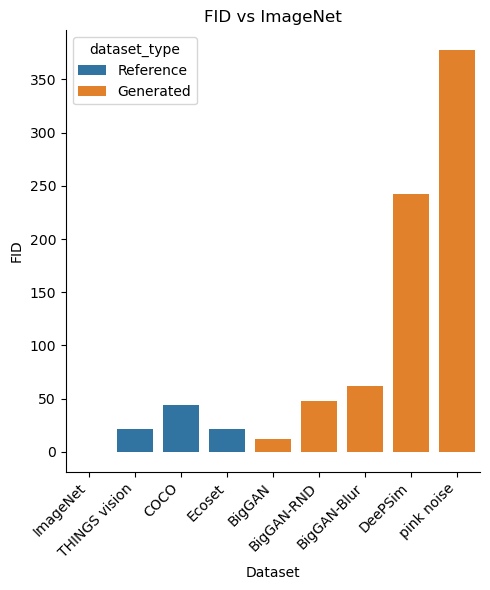

In [44]:
# Sort the data by FID value
plot_data = fid_stats_df.query("dataset2 == 'ImageNet_valid'",).sort_values("FID")
# add a column that label 'ImageNet_valid', 'THINGS_vision', 'COCO', 'Ecoset', these four as reference others as generated
plot_data["dataset_type"] = plot_data["dataset1"].apply(lambda x: "Reference" if x in ['ImageNet_valid', 'THINGS_vision', 'COCO', 'Ecoset'] else "Generated")
figh = plt.figure(figsize=(5, 6))
sns.barplot(data=plot_data, x="dataset1", y="FID", order=['ImageNet_valid',
       'THINGS_vision', 'COCO', 'Ecoset', 'BigGAN_trunc07', 'BigGAN_std_008',
       'BigGAN_Blur', 'DeePSim_4std', 'pink_noise', ], hue="dataset_type")
plt.xticks(rotation=45, ha='right')
# rename the xticks
plt.xticks(ticks=range(9), labels=['ImageNet',
       'THINGS vision', 'COCO', 'Ecoset', 'BigGAN', 'BigGAN-RND',
       'BigGAN-Blur', 'DeePSim', 'pink noise', ])
plt.title("FID vs ImageNet")
plt.xlabel("Dataset")
plt.ylabel("FID")
plt.tight_layout()
saveallforms(sumdir, "FID_vs_ImageNet", )

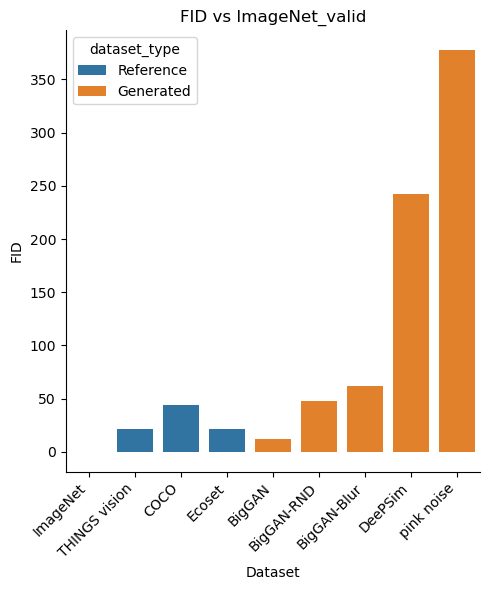

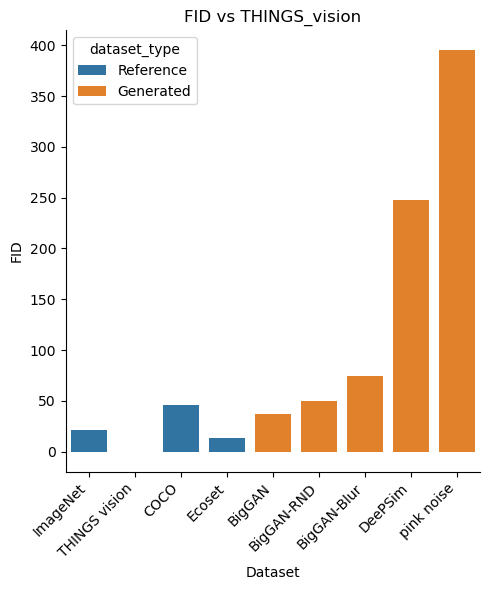

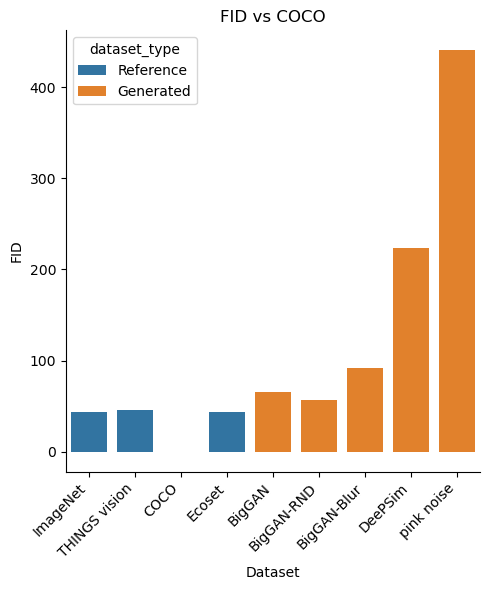

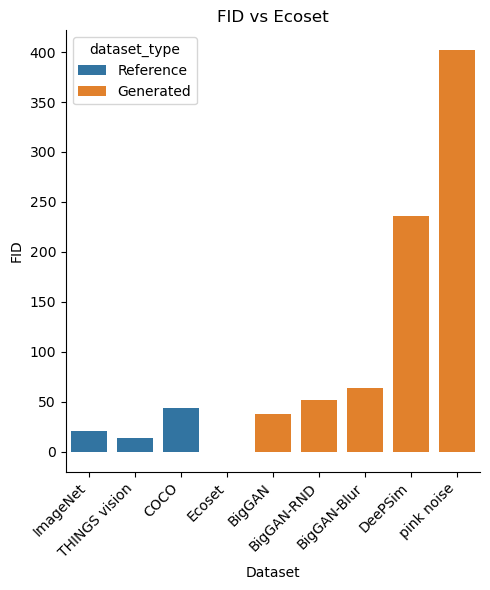

In [45]:
# Sort the data by FID value
for imageset_str_ref in refimageset_list:
    plot_data = fid_stats_df.query(f"dataset2 == '{imageset_str_ref}'",).sort_values("FID")
    # add a column that label 'ImageNet_valid', 'THINGS_vision', 'COCO', 'Ecoset', these four as reference others as generated
    plot_data["dataset_type"] = plot_data["dataset1"].apply(lambda x: "Reference" if x in ['ImageNet_valid', 'THINGS_vision', 'COCO', 'Ecoset'] else "Generated")
    figh = plt.figure(figsize=(5, 6))
    sns.barplot(data=plot_data, x="dataset1", y="FID", order=['ImageNet_valid',
        'THINGS_vision', 'COCO', 'Ecoset', 'BigGAN_trunc07', 'BigGAN_std_008',
        'BigGAN_Blur', 'DeePSim_4std', 'pink_noise', ], hue="dataset_type")
    plt.xticks(rotation=45, ha='right')
    # rename the xticks
    plt.xticks(ticks=range(9), labels=['ImageNet',
        'THINGS vision', 'COCO', 'Ecoset', 'BigGAN', 'BigGAN-RND',
        'BigGAN-Blur', 'DeePSim', 'pink noise', ])
    plt.title(f"FID vs {imageset_str_ref}")
    plt.xlabel("Dataset")
    plt.ylabel("FID")
    plt.tight_layout()
    saveallforms(sumdir, f"FID_vs_{imageset_str_ref}_summary_barplot", )

### Invert and Evolution

In [ ]:

biggan = BigGAN.from_pretrained("biggan-deep-256")
biggan.eval().requires_grad_(False).cuda()
BG = BigGAN_wrapper(biggan)
G = upconvGAN("fc6")
G.cuda().requires_grad_(False).eval()

imageset_str = "BigGAN_norm_std07"
BG_rn_fun = lambda batch_size: \
        BG.visualize(0.7 * torch.randn(batch_size, 256, device="cuda"))
#%%
imageset_str = "BigGAN_1000cls_std07"
BG_cls_fun = lambda batch_size: BG.visualize(BG.sample_vector(batch_size, class_id=None))

In [ ]:

#%%
target_img = BG_cls_fun(10)
z_init = torch.randn(10, 4096, device="cuda")
z_opt, img_opt, losses = GAN_invert(G, target_img, z_init, lr=2e-3, max_iter=2000, print_progress=False)
#%%
target_img = BG_cls_fun(40)
z_init = torch.randn(40, 4096, device="cuda")
z_opt, img_opt, losses = GAN_invert(G, target_img, z_init, lr=2e-3, max_iter=2000, print_progress=False)

#%%
show_imgrid(img_opt)
show_imgrid(target_img)
#%%
import sys
from os.path import join
if sys.platform == "linux":
    Hdir_fc6 = join("/home/biw905/Hessian", "Evolution_Avg_Hess.npz")  #r"/scratch/binxu/GAN_hessian/FC6GAN/summary/Evolution_Avg_Hess.npz"
else:
    Hdir_fc6 = r"E:\OneDrive - Washington University in St. Louis\Hessian_summary\fc6GAN\Evolution_Avg_Hess.npz"

H = np.load(Hdir_fc6)
#%%
# H_avg = H["H_avg"]
eigvecs = H["eigvect_avg"]
eigvecs_th = torch.from_numpy(eigvecs).float().cuda()
#%%
from torch.optim import Adam
from tqdm import trange
def GAN_Hessian_invert(G, target_img, eigvecs=None, z_init=None, lr=2e-3, weight_decay=0e-4, max_iter=5000, print_progress=True):
    if z_init is None:
        z_init = torch.randn(5, 4096, device="cuda")
    z_init = z_init.detach().clone()
    if target_img.device != "cuda":
        target_img = target_img.cuda()
    w_opt = z_init if eigvecs is None else (z_init @ eigvecs)
    w_opt.requires_grad_(True)
    opt = Adam([w_opt], lr=lr, weight_decay=weight_decay)
    pbar = trange(max_iter)
    for i in pbar:
        z_opt = w_opt if eigvecs is None else (w_opt @ eigvecs.t())
        img_opt = G.visualize(z_opt)
        losses = ((img_opt - target_img) ** 2).mean(dim=(1, 2, 3))  # changed from mean to sum
        loss = losses.sum()
        loss.backward()
        opt.step()
        opt.zero_grad()
        pbar.set_description(f"loss: {losses.mean().item():.3f}")
        if print_progress:
            print(i, losses.mean().item())
    img_opt = G.visualize(z_opt.detach())
    return z_opt, img_opt
#%%
target_img = BG_cls_fun(10)
z_init = torch.randn(10, 4096, device="cuda")
#%%
z_opt, img_opt_H = GAN_Hessian_invert(G, target_img, eigvecs=eigvecs_th, z_init=z_init, lr=2e-3, weight_decay=0e-4, max_iter=2000, print_progress=False)
# 1999 0.018893277272582054
z_opt, img_opt_noH = GAN_Hessian_invert(G, target_img, eigvecs=None, z_init=z_init, lr=2e-3, weight_decay=0e-4, max_iter=2000, print_progress=False)
# 0.015:
#%%
show_imgrid(img_opt_H, nrow=5)
show_imgrid(img_opt_noH, nrow=5)
